In [1]:
%run "/Shared/PySparkMagClass_2020-09-01"

In [2]:
AzureStorageAccount = '<AzureStorageAccount>'     # Azure Storage (AS) account containing MAG dataset
AzureStorageAccessKey = '<AzureStorageAccessKey>' # Access Key of the Azure Storage account
MagContainer = '<MagContainer>'                   # The container name in Azure Storage (AS) account containing MAG dataset, Usually in forms of mag-yyyy-mm-dd
FosId = 119857082  # machine learning
FosDisplayName = 'Machine Learning'

In [3]:
# create a MicrosoftAcademicGraph instance to access MAG dataset
MAG = MicrosoftAcademicGraph(container=MagContainer, account=AzureStorageAccount, key=AzureStorageAccessKey)

In [4]:
# load MAG data
magPapers = MAG.getDataframe('Papers')
magPaperFoses = MAG.getDataframe('PaperFieldsOfStudy')
magPaperAuthorAffiliations = MAG.getDataframe('PaperAuthorAffiliations')
magAffiliations = MAG.getDataframe('Affiliations')

In [5]:
import math

def getSaliency(rank) :
    return math.exp(float(rank)/-1000)
  
getSaliency_udf_func = udf(getSaliency, DoubleType())

In [6]:
# get target paperId
PapersId = magPaperFoses \
  .where(magPaperFoses.FieldOfStudyId == FosId) \
  .select(magPaperFoses.PaperId)

# join magPapers
Papers = magPapers \
  .where((magPapers.DocType.isNotNull()) & (magPapers.DocType != 'Patent') & (magPapers.DocType != 'Dataset')) \
  .join(PapersId, magPapers.PaperId == PapersId.PaperId, 'inner') \
  .select(magPapers.PaperId, \
          magPapers.FamilyId, \
          magPapers.Year, \
          getSaliency_udf_func(magPapers.Rank).alias('Saliency'), \
          magPapers.EstimatedCitation.alias('Citations'))

In [7]:
# Aggregate paper family
from pyspark.sql import functions as F

Paper_FamilyIdIsNull = Papers \
  .where(Papers.FamilyId.isNull()) \
  .select(Papers.PaperId, Papers.Year, Papers.Saliency, Papers.Citations)
         
Paper_FamilyIdNotNull_SC = Papers \
  .where(Papers.FamilyId.isNotNull()) \
  .groupBy('FamilyId') \
  .agg(F.sum('Saliency').alias('Saliency'), \
       F.sum('Citations').alias('Citations')) \
  .withColumnRenamed('FamilyId', 'PaperId')

Paper_FamilyIdNotNull_Year = Papers \
  .where((Papers.FamilyId.isNotNull()) & (Papers.FamilyId == Papers.PaperId)) \
  .select(Papers.PaperId, Papers.Year)

Paper_FamilyIdNotNull = Paper_FamilyIdNotNull_SC \
  .join(Paper_FamilyIdNotNull_Year, Paper_FamilyIdNotNull_SC.PaperId == Paper_FamilyIdNotNull_Year.PaperId, 'inner') \
  .select(Paper_FamilyIdNotNull_SC.PaperId, Paper_FamilyIdNotNull_Year.Year, Paper_FamilyIdNotNull_SC.Saliency, Paper_FamilyIdNotNull_SC.Citations)

PaperFamily = Paper_FamilyIdIsNull.union(Paper_FamilyIdNotNull)

In [8]:
# Filter papers with selected years
PaperYears = PaperFamily \
  .where((magPapers.Year >= 2000) & (magPapers.Year <= 2019))

In [9]:
# Get Affiliations with region
ISOcodeRegion = spark.table("isocode_region")

ISOcodeRegion = ISOcodeRegion \
  .where(ISOcodeRegion.Region.isin({'United States', 'EU', 'China', 'Japan'}))

AffiliationsWithRegion = magAffiliations \
  .join(ISOcodeRegion, magAffiliations.Iso3166Code == ISOcodeRegion.ISO3166Code, 'inner') \
  .select(magAffiliations.AffiliationId, ISOcodeRegion.Region)

In [10]:
# Get papers with affiliation Ids 
PapersAffiliations = PaperYears \
  .join(magPaperAuthorAffiliations, PaperYears.PaperId == magPaperAuthorAffiliations.PaperId, 'inner') \
  .where(magPaperAuthorAffiliations.AffiliationId.isNotNull()) \
  .select(Papers.PaperId, Papers.Year, Papers.Saliency, Papers.Citations, magPaperAuthorAffiliations.AffiliationId)

# Get paper with region
PapersAffiliationRegion = PapersAffiliations \
  .join(AffiliationsWithRegion, PapersAffiliations.AffiliationId == AffiliationsWithRegion.AffiliationId, 'inner') \
  .select(PapersAffiliations.PaperId, PapersAffiliations.Year, PapersAffiliations.Saliency, PapersAffiliations.Citations, PapersAffiliations.AffiliationId, AffiliationsWithRegion.Region)

# Eleminate duplicate
PapersRegion = PapersAffiliationRegion \
  .groupby('PaperId', 'Year', 'Saliency', 'Citations', 'Region').count()

# Aggregate to get paper stats for single region
RegionYearStats = PapersRegion \
  .groupby('Region', 'Year') \
  .agg(F.count('PaperId').alias('PaperCount'), \
       F.sum('Saliency').alias('Saliency'), \
       F.sum('Citations').alias('Citations')) 

In [11]:
# import libiaries for drawing figure
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [12]:
# convert Spark dataFrame to Pandas dataFrame for graph drawing
RegionYearStatsPandas = RegionYearStats.toPandas()

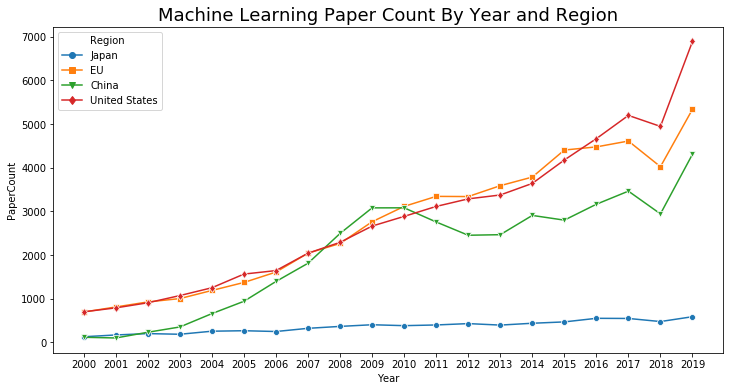

In [13]:
# set figures size
plt.figure(figsize=(12, 6))

# set seaborn lineplot
ax_papercount = plt.subplot()
ax_papercount = sns.lineplot(x="Year", y="PaperCount", hue="Region", style="Region", markers=['o','s','v','d'], dashes=False, data=RegionYearStatsPandas)

# set figure
ax_papercount.set_title(FosDisplayName + " Paper Count By Year and Region", fontsize=18)
ax_papercount.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))
ax_papercount.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(loc='upper left')

# display figure
plt.show()

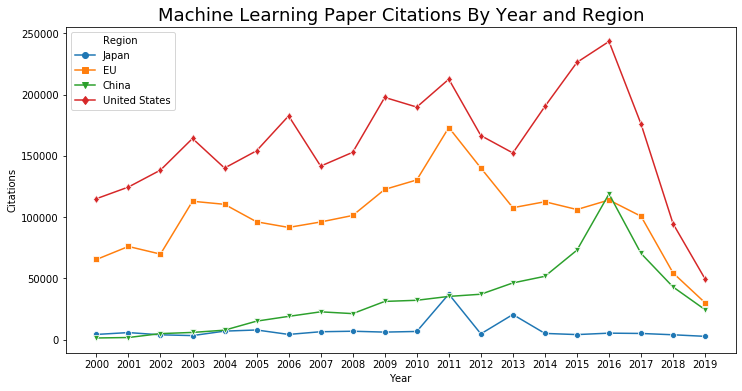

In [14]:
# set figures size
plt.figure(figsize=(12, 6))

# set seaborn lineplot
ax_citations = plt.subplot()
ax_citations = sns.lineplot(x="Year", y="Citations", hue="Region", style="Region", markers=['o','s','v','d'], dashes=False, data=RegionYearStatsPandas)

# set figure
ax_citations.set_title(FosDisplayName + " Paper Citations By Year and Region", fontsize=18)
ax_citations.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))
ax_citations.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(loc='upper left')

# display figure
plt.show()

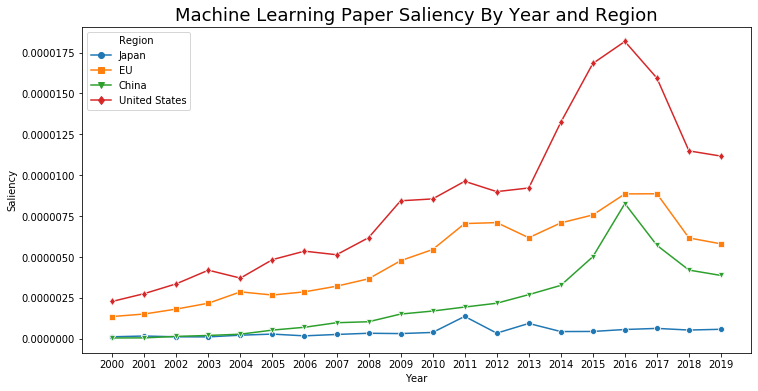

In [15]:
# set figures size
plt.figure(figsize=(12, 6))

# set seaborn lineplot
ax_saliency = plt.subplot()
ax_saliency = sns.lineplot(x="Year", y="Saliency", hue="Region", style="Region", markers=['o','s','v','d'], dashes=False, data=RegionYearStatsPandas)

# set figure
ax_saliency.set_title(FosDisplayName + " Paper Saliency By Year and Region", fontsize=18)
ax_saliency.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))
ax_saliency.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(loc='upper left')

# display figure
plt.show()

In [16]:
# Separate papers by region
PapersRegion_US = PapersRegion \
  .where(PapersRegion.Region == 'United States') \
  .select(PapersRegion.PaperId, PapersRegion.Year, PapersRegion.Saliency, PapersRegion.Citations)

PapersRegion_EU = PapersRegion \
  .where(PapersRegion.Region == 'EU') \
  .select(PapersRegion.PaperId, PapersRegion.Year, PapersRegion.Saliency, PapersRegion.Citations)

PapersRegion_China = PapersRegion \
  .where(PapersRegion.Region == 'China') \
  .select(PapersRegion.PaperId, PapersRegion.Year, PapersRegion.Saliency, PapersRegion.Citations)

PapersRegion_Japan = PapersRegion \
  .where(PapersRegion.Region == 'Japan') \
  .select(PapersRegion.PaperId, PapersRegion.Year, PapersRegion.Saliency, PapersRegion.Citations)

PapersRegion_US_EU = PapersRegion_US \
  .join(PapersRegion_EU, PapersRegion_US.PaperId == PapersRegion_EU.PaperId, 'inner') \
  .select(PapersRegion_US.PaperId, PapersRegion_US.Year, PapersRegion_US.Saliency, PapersRegion_US.Citations)

PapersRegion_US_China = PapersRegion_US \
  .join(PapersRegion_China, PapersRegion_US.PaperId == PapersRegion_China.PaperId, 'inner') \
  .select(PapersRegion_US.PaperId, PapersRegion_US.Year, PapersRegion_US.Saliency, PapersRegion_US.Citations)

PapersRegion_EU_China = PapersRegion_EU \
  .join(PapersRegion_China, PapersRegion_EU.PaperId == PapersRegion_China.PaperId, 'inner') \
  .select(PapersRegion_EU.PaperId, PapersRegion_EU.Year, PapersRegion_EU.Saliency, PapersRegion_EU.Citations)

PapersRegion_US_EU_China = PapersRegion_US_EU \
  .join(PapersRegion_China, PapersRegion_US_EU.PaperId == PapersRegion_China.PaperId, 'inner') \
  .select(PapersRegion_US_EU.PaperId, PapersRegion_US_EU.Year, PapersRegion_US_EU.Saliency, PapersRegion_US_EU.Citations)

In [17]:
# Aggregate to get paper stats for regional collaboration
from pyspark.sql.functions import lit

RegionYearStats_US_EU = PapersRegion_US_EU \
  .groupby('Year') \
  .agg(F.count('PaperId').alias('PaperCount'), \
       F.sum('Saliency').alias('Saliency'), \
       F.sum('Citations').alias('Citations')) \
  .withColumn("Region", lit("US/EU"))

RegionYearStats_US_China = PapersRegion_US_China \
  .groupby('Year') \
  .agg(F.count('PaperId').alias('PaperCount'), \
       F.sum('Saliency').alias('Saliency'), \
       F.sum('Citations').alias('Citations')) \
  .withColumn("Region", lit("US/China"))

RegionYearStats_EU_China = PapersRegion_EU_China \
  .groupby('Year') \
  .agg(F.count('PaperId').alias('PaperCount'), \
       F.sum('Saliency').alias('Saliency'), \
       F.sum('Citations').alias('Citations')) \
  .withColumn("Region", lit("EU/China"))

RegionYearStats_US_EU_China = PapersRegion_US_EU_China \
  .groupby('Year') \
  .agg(F.count('PaperId').alias('PaperCount'), \
       F.sum('Saliency').alias('Saliency'), \
       F.sum('Citations').alias('Citations')) \
  .withColumn("Region", lit("US/EU/China"))

RegionCollaborationYearStats = RegionYearStats_US_EU \
  .union(RegionYearStats_US_China) \
  .union(RegionYearStats_EU_China) \
  .union(RegionYearStats_US_EU_China)

In [18]:
# convert Spark dataFrame to Pandas dataFrame for graph drawing
RegionCollaborationYearStatsPandas = RegionCollaborationYearStats.toPandas()

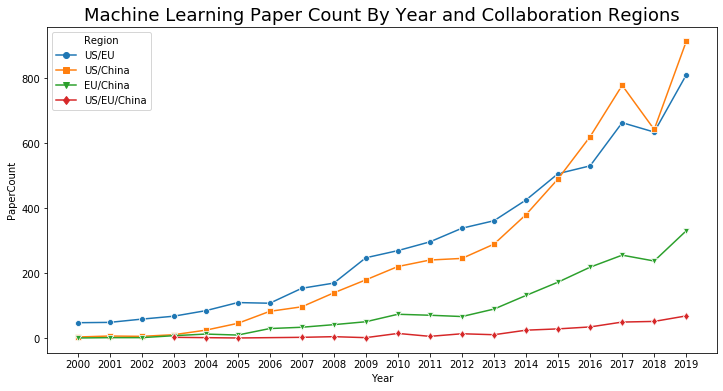

In [19]:
# set figures size
plt.figure(figsize=(12, 6))

# set seaborn lineplot
ax_c_papercount = plt.subplot()
ax_c_papercount = sns.lineplot(x="Year", y="PaperCount", hue="Region", style="Region", markers=['o','s','v','d'], dashes=False, data=RegionCollaborationYearStatsPandas)

# set figure
ax_c_papercount.set_title(FosDisplayName + " Paper Count By Year and Collaboration Regions", fontsize=18)
ax_c_papercount.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))
ax_c_papercount.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(loc='upper left')

# display figure
plt.show()

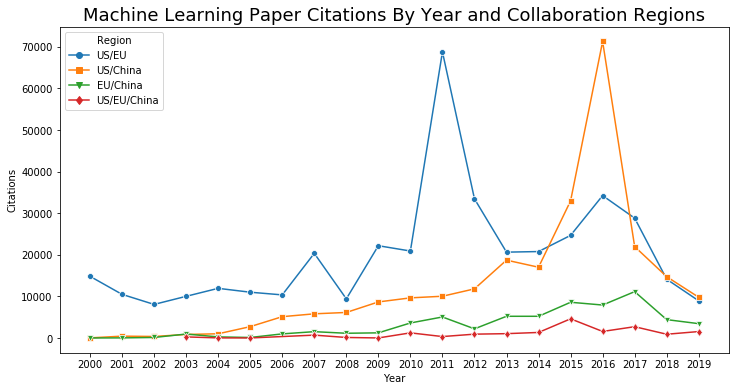

In [20]:
# set figures size
plt.figure(figsize=(12, 6))

# set seaborn lineplot
ax_c_papercount = plt.subplot()
ax_c_papercount = sns.lineplot(x="Year", y="Citations", hue="Region", style="Region", markers=['o','s','v','d'], dashes=False, data=RegionCollaborationYearStatsPandas)

# set figure
ax_c_papercount.set_title(FosDisplayName + " Paper Citations By Year and Collaboration Regions", fontsize=18)
ax_c_papercount.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))
ax_c_papercount.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(loc='upper left')

# display figure
plt.show()

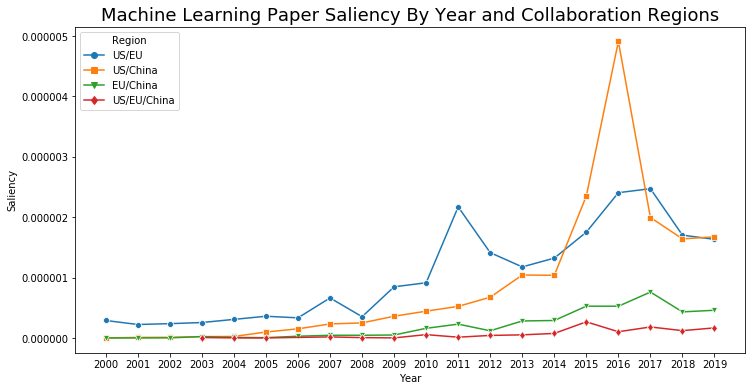

In [21]:
# set figures size
plt.figure(figsize=(12, 6))

# set seaborn lineplot
ax_c_papercount = plt.subplot()
ax_c_papercount = sns.lineplot(x="Year", y="Saliency", hue="Region", style="Region", markers=['o','s','v','d'], dashes=False, data=RegionCollaborationYearStatsPandas)

# set figure
ax_c_papercount.set_title(FosDisplayName + " Paper Saliency By Year and Collaboration Regions", fontsize=18)
ax_c_papercount.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))
ax_c_papercount.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(loc='upper left')

# display figure
plt.show()